In [2]:
%pip install scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 5.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


['/Library/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/owenkadis/Library/Python/3.12/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages']


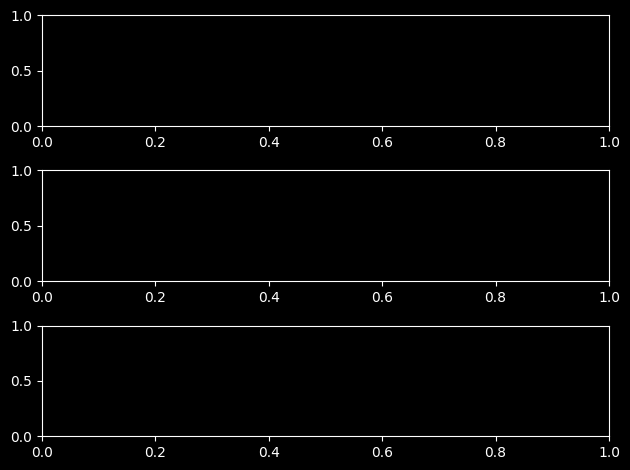

In [3]:
import math
import datetime
import sys
print(sys.path)
from datetime import timedelta
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy import stats

class EuropeanCall:

    def d1(self, asset_price, strike_price, risk_free_rate, volatility, dt):
        return (np.log((asset_price/strike_price)) + (risk_free_rate + np.power(volatility,2)/2)*dt)/(volatility*np.sqrt(dt))

    def d2(self, d1, volatility, dt):
        return d1 - (volatility*np.sqrt(dt))

    def price(self, asset_price, d1, strike_price, d2, risk_free_rate, dt):
        # Calculate NormalCDF for d1 & d2
        n1 = stats.norm.cdf(d1)
        n2 = stats.norm.cdf(d2)
        # Calculate call option price
        return asset_price*n1 - strike_price*(np.exp(-(risk_free_rate*dt)))*n2

    def delta(self, d1):
        return stats.norm.cdf(d1)

    def exercise_prob(self):
        return 1 - stats.norm.cdf(((self.strike_price - self.asset_price) - (self.drift*self.asset_price*self.dt))/((self.volatility*self.asset_price)*(self.dt**.5)))


    def __init__(self, asset_price, strike_price, volatility, expiration_date, risk_free_rate, drift):
        self.asset_price = asset_price
        self.strike_price = strike_price
        self.volatility = volatility
        self.expiration_date = expiration_date
        self.risk_free_rate = risk_free_rate
        self.drift = drift
        # Calculate delta t
        dt = 59/252
        #dt = np.busday_count(datetime.date.today(), expiration_date) / 252
        # Calculate d1
        d1 = self.d1(asset_price, strike_price, risk_free_rate, volatility, dt)
        # Calculate d2
        d2 = self.d2(d1, volatility, dt)
        self.dt = dt
        self.price = self.price(asset_price, d1, strike_price, d2, risk_free_rate, dt)
        self.delta = self.delta(d1)


class EuropeanPut:

    def d1(self, asset_price, strike_price, risk_free_rate, volatility, dt):
        return (np.log((asset_price/strike_price)) + (risk_free_rate + np.power(volatility,2)/2)*dt)/(volatility*np.sqrt(dt))

    def d2(self, d1, volatility, dt):
        return d1 - (volatility*np.sqrt(dt))

    def price(self, asset_price, d1, strike_price, d2, risk_free_rate, dt):
        # Calculate NormalCDF for d1 & d2
        n1 = stats.norm.cdf(-d1)
        n2 = stats.norm.cdf(-d2)
        # Calculate call option price
        return strike_price*(np.exp(-(risk_free_rate*dt)))*n2 - asset_price*n1

    def delta(self, d1):
        return stats.norm.cdf(d1) - 1

    def exercise_prob(self):
        return stats.norm.cdf(((self.strike_price - self.asset_price) - (self.drift*self.asset_price*self.dt))/((self.volatility*self.asset_price)*(self.dt**.5)))

    def __init__(self, asset_price, strike_price, volatility, expiration_date, risk_free_rate, drift):
        self.asset_price = asset_price
        self.strike_price = strike_price
        self.volatility = volatility
        self.expiration_date = expiration_date
        self.risk_free_rate = risk_free_rate
        self.drift = drift
        # Calculate delta t
        dt = np.busday_count(datetime.date.today(), expiration_date) / 252
        # Calculate d1
        d1 = self.d1(asset_price, strike_price, risk_free_rate, volatility, dt)
        # Calculate d2
        d2 = self.d2(d1, volatility, dt)
        self.dt = dt
        self.price = self.price(asset_price, d1, strike_price, d2, risk_free_rate, dt)
        self.delta = self.delta(d1)
        self.asset_price = asset_price


# Adjust for delta t
class LiveOptionsGraph:

    # Portfolio tick
    # Can be modified by appending new realtime data rather than randomly generated data
    def time_step(self, z):
        # Calculate dt so we can draw from a normal distribution to model the asset price
        dt = np.busday_count(datetime.date.today(), self.expiration_date) / 252
        if dt != 0:
            if(self.type == 'call'):
                eo = EuropeanCall(self.asset_prices[self.index] + np.random.normal(0, dt**(1/2)), self.strike_price, self.volatility, self.expiration_date, self.risk_free_rate, self.drift)
            elif(self.type == 'put'):
                eo = EuropeanPut(self.asset_prices[self.index] + np.random.normal(0, dt**(1/2)), self.strike_price, self.volatility, self.expiration_date, self.risk_free_rate, self.drift)
            self.option_prices.append(eo.price)
            self.deltas.append(eo.delta)
            self.index_set.append(self.index)
            self.axs[0].cla()
            self.axs[1].cla()
            self.axs[2].cla()
            self.axs[0].plot(self.index_set, self.option_prices, label='Black-Scholes Option Price', c='b')
            self.axs[1].plot(self.index_set, self.deltas, label='Delta', c='gray')

            # Plot the asset price and strike price on the 3rd plot, green if in the money red if out of the money
            if self.type == 'call':
                if self.strike_price <= self.asset_prices[self.index]:
                    self.axs[2].plot(self.index_set, self.asset_prices, label='Asset Price', c='g')
                    self.axs[2].axhline(y=self.strike_price, label='Call Strike Price', c='gray')
                else:
                    self.axs[2].plot(self.index_set, self.asset_prices, label='Asset Price', c='r')
                    self.axs[2].axhline(y=self.strike_price, label='Call Strike Price', c='gray')
            elif self.type == 'put':
                if self.strike_price < self.asset_prices[self.index]:
                    self.axs[2].plot(self.index_set, self.asset_prices, label='Asset Price', c='r')
                    self.axs[2].axhline(y=self.strike_price, label='Put Strike Price', c='gray')
                else:
                    self.axs[2].plot(self.index_set, self.asset_prices, label='Asset Price', c='g')
                    self.axs[2].axhline(y=self.strike_price, label='Put Strike Price', c='gray')

            self.axs[0].legend(loc='upper left')
            self.axs[1].legend(loc='upper left')
            self.axs[2].legend(loc='upper left')
            self.asset_prices.append(eo.asset_price)
            self.index = self.index + 1
            # Helps display time decay
            self.expiration_date = self.expiration_date - timedelta(days=1)

    def __init__(self, european_option, type):
        self.index = 0
        self.asset_price = european_option.asset_price
        self.strike_price = european_option.strike_price
        self.volatility = european_option.volatility
        self.expiration_date = european_option.expiration_date
        self.risk_free_rate = european_option.risk_free_rate
        self.drift = european_option.drift
        self.type = type
        self.index_set = []
        self.option_prices = []
        self.asset_prices = [european_option.asset_price]
        self.deltas = []
        plt.style.use('dark_background')
        self.fig, self.axs = plt.subplots(3)
        self.ani = FuncAnimation(plt.gcf(), self.time_step, 100)
        plt.tight_layout()
        plt.show()


initial_ec = EuropeanCall(64.5, 65, .4, datetime.date(2020, 1, 31), .06, .2)
lg = LiveOptionsGraph(initial_ec, 'call')